# Determination of age by photo

## Exploratory data analysis

In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info(), display(labels.head()), display(labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

(None, None, None)

The data and their markup are obtained from the APPA-REAL database, which includes both the reliable age and the age obtained by evaluating by other people (on average 38 votes for each photo):

*The APPA-REAL database contains 7,591 images with associated real and apparent age labels. The total number of apparent votes is around 250,000. On average we have around 38 votes per each image and this makes the average apparent age very stable (0.3 standard error of the mean).*

We have only a sign with real age at our disposal.

In [4]:
# labels['real_age'].plot(kind='hist', figsize=(12, 5), bins=100, title='Distribution of data by age')

In [5]:
px.histogram(
    labels, x = 'real_age', marginal = 'box', 
    title = 'Distribution of data by age').show()

**Conclusion:**
- the data is in the correct format
- there are no gaps
- distribution of values is close to normal Gaussian, skewed to the right, if we consider the data in abstract
- if we consider in relation to the general distribution of the ages of people, then our data is not distributed appropriately
- no outliers, the distribution of lived years from 1 to 100 looks realistic
- there are peaks in the region of 1 year, 25, 30, 40 and 50 years and all other round dates. Possible reasons:
 - at this age, photos were either uploaded or uploaded for the dataset
 - the age data we have includes not only the real age, but also the estimates of people: it is reasonable that people will predict a round number
- there is a gap in the data from 8 to 12 years inclusive and very little data after 71: there is a possibility that this can reduce the accuracy of age determination for these groups

In [6]:
datagen = ImageDataGenerator(rescale=1./255) 

In [7]:
datagen_flow = datagen.flow_from_dataframe(
    dataframe = labels, 
    directory='/datasets/faces/final_files',
    x_col='file_name', y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


**Conclusion:** For training and verification, we have 7591 images:
- this is enough to train and test our model
- to improve the quality in the training sample, it is worth applying augmentation: duplicate photos with their reflection horizontally (this is suitable for faces)
- it is not worth reflecting vertically if we do not plan to open a store in Australia
- cropping, rotating, enlarging the photo is not necessary (but we could try), since the photos were already preprocessed for us so that all the faces were located approximately the same:
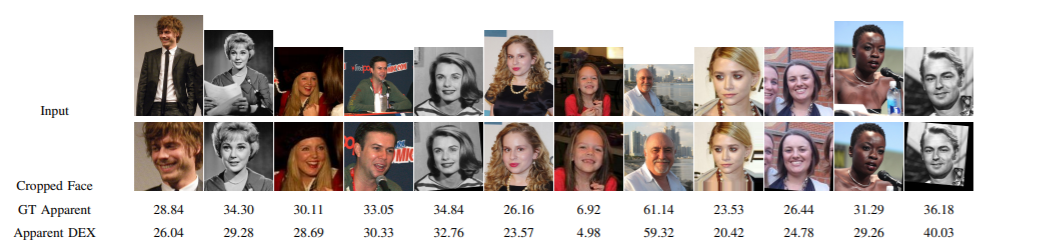


In [8]:
features, target = next(datagen_flow)

In [9]:
print(features.shape)
print(target.shape)

(16, 150, 150, 3)
(16,)


The shape show:
- Batch size - 16 images
- Image size - 150 x 150 pixels
- Layers - 3 RGB layers

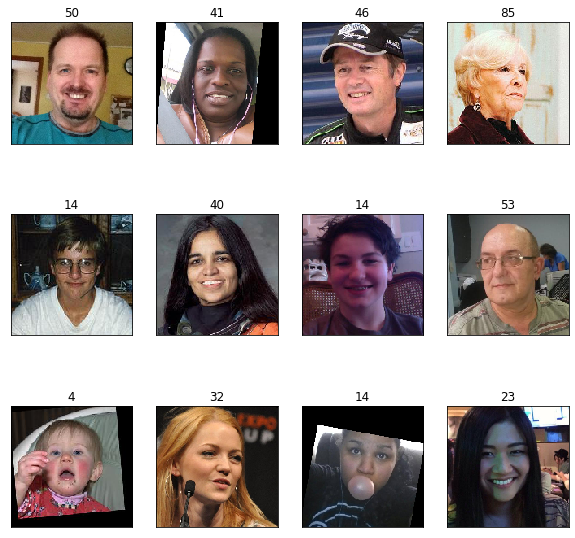

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])


**Conclusions:**
- The faces in the photo are already well cropped, it has already been done before us:
  - all photos are brought to the same size
  - all faces are located in the center of the frame
  - removed the slope of the faces - they are all located approximately vertically
- All faces are clearly visible, in focus. Photos have adequate brightness, clarity and contrast.
- Age looks relatively believable (although the child seems to me clearly younger than 4 years old)

**General conclusion:**
- We can work with existing data
- To improve accuracy, we can apply augmentation: flip the photo horizontally
- It would also not hurt:
  - Check age (is it real or based on surveys)
  - Compare the results of the model, after applying augmentation: tilt, change in clarity, brightness
  - Replenish poorly represented age groups

## Model training

```python
def load_train(path):
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255,
        validation_split=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name', y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow

def load_test(path):
    
    labels = pd.read_csv('/datasets/faces/labels.csv')

    test_datagen = ImageDataGenerator(
        rescale=1 / 255,
        validation_split=0.2)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name', y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mae',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

```python

Train for 380 steps, validate for 95 steps
Epoch 1/10
380/380 - 94s - loss: 10.9044 - mae: 10.9085 - val_loss: 15.5744 - val_mae: 15.5703
Epoch 2/10
380/380 - 40s - loss: 7.7739 - mae: 7.7759 - val_loss: 9.6035 - val_mae: 9.6041
Epoch 3/10
380/380 - 40s - loss: 6.6842 - mae: 6.6860 - val_loss: 6.5817 - val_mae: 6.5825
Epoch 4/10
380/380 - 40s - loss: 5.9365 - mae: 5.9395 - val_loss: 7.1690 - val_mae: 7.1695
Epoch 5/10
380/380 - 40s - loss: 5.3708 - mae: 5.3734 - val_loss: 7.3001 - val_mae: 7.2977
Epoch 6/10
380/380 - 40s - loss: 4.9574 - mae: 4.9587 - val_loss: 6.6686 - val_mae: 6.6675
Epoch 7/10
380/380 - 40s - loss: 4.4767 - mae: 4.4791 - val_loss: 6.3400 - val_mae: 6.3388
Epoch 8/10
380/380 - 40s - loss: 4.1216 - mae: 4.1225 - val_loss: 6.5551 - val_mae: 6.5564
Epoch 9/10
380/380 - 39s - loss: 3.8380 - mae: 3.8382 - val_loss: 6.6988 - val_mae: 6.6979
Epoch 10/10
380/380 - 40s - loss: 3.6620 - mae: 3.6648 - val_loss: 6.9065 - val_mae: 6.9062

95/95 - 8s - loss: 6.9065 - mae: 6.9062
Test MAE: 6.9062
```

## Analyzing the trained model

- Well-cropped, validated and labeled images were taken to train (and validate) the model
- To train the model, we took the proven convolutional neural network ResNet50, which we tuned for the regression problem with the metric Average absolute error (MAE). Also, the training photos were flipped horizontally, which is reasonable for faces.
- Over 10 epochs, the network reached an indicator of 6.9 on the validation data, while it is clear that at the seventh epoch the indicator was even lower - **6.33**, so we can stop at seven epochs. Further, we can see that the metric decreases on the training data, but increases on the test data, which indicates retraining.
- To improve the result, we can work with other architectures, a lot of research has already been done in the field of age determination and there are architectures that show more accurate results (but work slower):
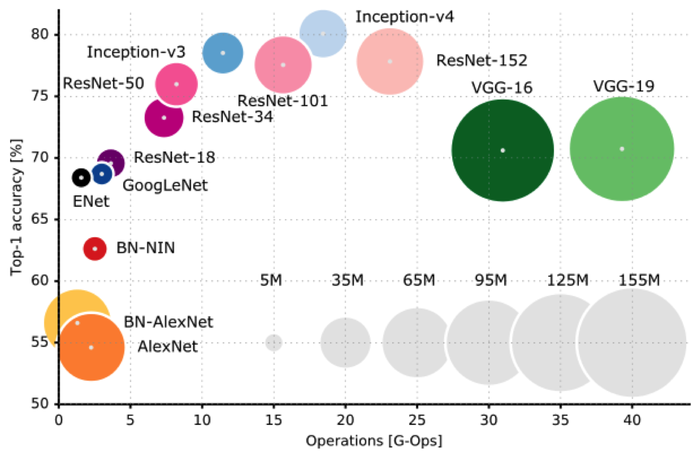